In [3]:
import torch
import torch.nn as nn

import numpy as np

from scipy.interpolate import griddata

import matplotlib.pyplot as plt


# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA')
else:
    device = torch.device('cpu')
    print('CPU')

CUDA


In [4]:
torch.cuda.is_available()

True

In [5]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

In [6]:
# Creating Neural Network
class NN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        # initialize weight and Biases
        nn.init.xavier_uniform_(self.l1.weight)
        self.l1.bias.data.fill_(0.0)

        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l2.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l2.weight)

        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l3.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l3.weight)

        self.l4 = nn.Linear(hidden_size, output_size)
        nn.init.xavier_uniform_(self.l4.weight)
        self.l4.bias.data.fill_(0.0)

    def forward(self, x):
        out = self.l1(x)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        out = self.tanh(out)
        out = self.l4(out)
        return out

In [7]:
class PINN:
    # Initialize the class
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size):
        
        # Normalization 
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # weights
        self.lam_u_val = torch.tensor(1.0).float().to(device)
        self.lam_ut_val = torch.tensor(1.0).float().to(device)
        self.lam_r_val = torch.tensor(1.0).float().to(device)
        
        # Wave constant
        self.c = torch.tensor(c).float().to(device)
        
        self.kernel_size = kernel_size # Size of the NTK matrix

        self.D1 = self.kernel_size    # boundary
        self.D2 = self.kernel_size    # ut   
        self.D3 = self.kernel_size    # residual  D1 = D3 = 3D2
        
        # Neural Network
        self.nn = NN(layers[0], layers[1], layers[-1]).to(device)

        self.optimizer_Adam = torch.optim.Adam(params=self.nn.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=self.optimizer_Adam, gamma=0.9)
        
        # Logger
        self.loss_bcs_log = []
        self.loss_ut_ics_log = []
        self.loss_res_log = []
         
        # NTK logger 
        self.K_u_log = []
        self.K_ut_log = []
        self.K_r_log = []
        
        # weights logger
        self.lam_u_log = []
        self.lam_ut_log = []
        self.lam_r_log = [] 
    
    # Forward pass for u
    def net_u(self, t, x):
            
        if x.dim()==0:
            x = x.reshape(1)
            t = t.reshape(1)
            u = self.nn(torch.cat([t, x], dim=0))
        else:
            u = self.nn(torch.cat([t, x], dim=1))
        return u

    # Forward pass for du/dt
    def net_u_t(self, t, x):

        u = self.net_u(t, x)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            create_graph=True,
        )[0] / self.sigma_t
        return u_t

    # Forward pass for the residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x,
                                 self.c,
                                 self.sigma_t,
                                 self.sigma_x)
        return residual
    
    # Gradient operation
    def gradient(self, y, x, grad_outputs=None):
        if grad_outputs is None:
            grad_outputs = torch.ones_like(y)
        grad = torch.autograd.grad(y, [x], grad_outputs = grad_outputs, create_graph=True, allow_unused=True)[0]
        return grad

    # Compute Jacobian for each weights and biases in each layer and return a list 
    def compute_jacobian(self, output, params):
        output = output.reshape(-1)
        J_dum = []
        J_List = []
        
        for i in range(len(params)):
            grad, = torch.autograd.grad(output, params[i], (torch.eye(output.shape[0]).to(device),),retain_graph=True, allow_unused=True, is_grads_batched=True)
            if grad == None:
                pass
            else:
                J_dum.append(grad)

                if np.mod(i,2)==1:
                    if grad == None:
                        pass
                    J_List.append(torch.cat((J_dum[i-1].flatten().reshape(len(output),-1),grad.flatten().reshape(len(output),-1)), 1))
        return J_List

    # Compute Neural Tangent Kernel's Trace Values
    def compute_ntk(self, J1, d1, J2, d2):
        
        Ker = torch.zeros((d1,d2)).float().to(device)

        for i in range(len(J1)):
            K = torch.matmul(J1[i], J2[i].t())
            Ker = Ker + K       
        return Ker


    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    # Trains the model by minimizing the MSE loss
    def train(self, nIter=10000, batch_size=128, log_NTK=False, update_lam=False):
        
        # NTK
        self.nn.train()
        
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size // 3)
            X_bc1_batch, _ = self.fetch_minibatch(self.bcs_sampler[0], batch_size // 3)
            X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], batch_size // 3)
            
            # Tensor
            X_ics_batch_tens = torch.tensor(X_ics_batch, requires_grad=True).float().to(device)
            u_ics_batch_tens = torch.tensor(u_ics_batch, requires_grad=True).float().to(device)
            X_bc1_batch_tens = torch.tensor(X_bc1_batch, requires_grad=True).float().to(device)
            X_bc2_batch_tens = torch.tensor(X_bc2_batch, requires_grad=True).float().to(device)
            
            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)
            X_res_batch_tens = torch.tensor(X_res_batch, requires_grad=True).float().to(device)
            
            u_pred_ics = self.net_u(X_ics_batch_tens[:, 0:1], X_ics_batch_tens[:, 1:2])
            u_t_pred_ics = self.net_u_t(X_ics_batch_tens[:, 0:1], X_ics_batch_tens[:, 1:2])
            u_pred_bc1 = self.net_u(X_bc1_batch_tens[:, 0:1], X_bc1_batch_tens[:, 1:2])
            u_pred_bc2 = self.net_u(X_bc2_batch_tens[:, 0:1], X_bc2_batch_tens[:, 1:2])
            r_pred = self.net_r(X_res_batch_tens[:, 0:1], X_res_batch_tens[:, 1:2])
            
            loss_bcs = torch.mean((u_ics_batch_tens - u_pred_ics) ** 2) + torch.mean(u_pred_bc1 ** 2) + torch.mean(u_pred_bc2 ** 2)
            loss_ics_u_t = torch.mean(u_t_pred_ics ** 2)
            loss_res = torch.mean(r_pred ** 2)

            loss = self.lam_r_val * loss_res + self.lam_u_val * loss_bcs + self.lam_ut_val * loss_ics_u_t 
            
            # Backward and optimize 
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            if it % 1000 == 0:
                self.my_lr_scheduler.step()
            
            # Print
            if it % 100 == 0:

                # Store losses
                self.loss_bcs_log.append(loss_bcs.detach().cpu().numpy())
                self.loss_res_log.append(loss_res.detach().cpu().numpy())
                self.loss_ut_ics_log.append(loss_ics_u_t.detach().cpu().numpy())

                print('It: %d, Loss: %.3e, Loss_res: %.3e,  Loss_bcs: %.3e, Loss_ut_ics: %.3e' %
                      (it, loss.item(), loss_res, loss_bcs, loss_ics_u_t))
                
                print(f'lambda_u: {self.lam_u_val:3e}')
                print(f'lambda_ut: {self.lam_ut_val:3e}')
                print(f'lambda_r: {self.lam_r_val:3e}')
          
            if log_NTK:
                
                if it % 100 == 0:
                    print("Compute NTK...")
                    X_bc_batch = np.vstack([X_ics_batch, X_bc1_batch, X_bc2_batch])
                    X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size )
                    
                    # Convert to the tensor
                    X_bc_batch_tens = torch.tensor(X_bc_batch, requires_grad=True).float().to(device)
                    X_ics_batch_tens = torch.tensor(X_ics_batch, requires_grad=True).float().to(device)
                    u_ics_batch_tens = torch.tensor(u_ics_batch, requires_grad=True).float().to(device)

                    # Get the parameters of NN
                    params = list(self.nn.parameters())
                    
                    # Store the trace 
                    K_u_value = 0
                    K_ut_value = 0
                    K_r_value = 0
                    
                    u_ntk_pred = self.net_u(X_bc_batch_tens[:,0:1], X_bc_batch_tens[:,1:2])
                    u_t_ntk_pred = self.net_u_t(X_ics_batch_tens[:,0:1], X_ics_batch_tens[:,1:2])
                    r_ntk_pred = self.net_r(X_res_batch_tens[:,0:1], X_res_batch_tens[:,1:2])

                    # Jacobian of the neural networks
                    J_u = self.compute_jacobian(u_ntk_pred, params)
                    J_ut = self.compute_jacobian(u_t_ntk_pred, params)
                    J_r = self.compute_jacobian(r_ntk_pred, params)

                    # Neural tangent kernels of the neural networks / Trace values
                    K_u_value = self.compute_ntk(J_u, self.D1, J_u, self.D1)
                    K_ut_value = self.compute_ntk(J_ut, self.D2, J_ut, self.D2)
                    K_r_value = self.compute_ntk(J_r, self.D3, J_r, self.D3)

                    # Convert tensor to numpy array
                    K_u_value = K_u_value.detach().cpu().numpy()
                    K_ut_value = K_ut_value.detach().cpu().numpy()
                    K_r_value = K_r_value.detach().cpu().numpy()
                    
                    trace_K = np.trace(K_u_value) + np.trace(K_ut_value) + np.trace(K_r_value)
  
                    # Store Trace values
                    self.K_u_log.append(K_u_value)
                    self.K_ut_log.append(K_ut_value)
                    self.K_r_log.append(K_r_value)
                        
                    if update_lam:

                        self.lam_u_val = trace_K / np.trace(K_u_value)
                        self.lam_ut_val = trace_K / np.trace(K_ut_value)
                        self.lam_r_val = trace_K / np.trace(K_r_value)

                        # Store NTK weights
                        self.lam_u_log.append(self.lam_u_val)
                        self.lam_ut_log.append(self.lam_ut_val)
                        self.lam_r_log.append(self.lam_r_val)
          
    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        
        t = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        self.nn.eval()

        u_star = self.net_u(t, x)
        u_star = u_star.detach().cpu().numpy()
        return u_star

    # Evaluates predictions at test points
    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        
        t = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)
        
        self.nn.eval()

        r_star = self.net_r(t, x)
        r_star = r_star.detach().cpu().numpy()
        return r_star

In [8]:
# Define the exact solution and its derivatives
def u(x, a, c):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(np.pi * x) * np.cos(c * np.pi * t) + \
            a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = -  c * np.pi * np.sin(np.pi * x) * np.sin(c * np.pi * t) - \
            a * 4 * c * np.pi * np.sin(2 * c * np.pi* x) * np.sin(4 * c * np.pi * t)
    return u_t

def u_tt(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -(c * np.pi)**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - \
            a * (4 * c * np.pi)**2 *  np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return u_tt

def u_xx(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = - np.pi**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - \
              a * (2 * c * np.pi)** 2 * np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return  u_xx

def r(x, a, c):
    return u_tt(x, a, c) - c**2 * u_xx(x, a, c)

def operator(u, t, x, c, sigma_t=1.0, sigma_x=1.0):

    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0] / sigma_t
    
    u_tt = torch.autograd.grad(
        u_t, t, 
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0] / sigma_t
    
    u_x = torch.autograd.grad(
        u, x, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0] / sigma_x

    u_xx = torch.autograd.grad(
        u_x, x, 
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0] / sigma_x     
    
    residual = u_tt - c**2 * u_xx
    return residual

In [9]:
# Domain boundaries
ics_coords = np.array([[0.0, 0.0],
                        [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],
                        [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],
                        [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],
                        [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')

In [10]:
# Define PINN model
a = 0.5
c = 2

layers = [2, 500, 500, 500, 1]
kernel_size = 300
model = PINN(layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size)

In [19]:
# Train model
itertaions = 5000
log_NTK = True # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK 

model.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

It: 0, Loss: 2.292e+01, Loss_res: 5.828e-01,  Loss_bcs: 1.433e-01, Loss_ut_ics: 5.803e-02
lambda_u: 1.471731e+02
lambda_ut: 2.091571e+01
lambda_r: 1.057760e+00
Compute NTK...
It: 100, Loss: 2.275e+01, Loss_res: 1.425e+00,  Loss_bcs: 1.255e-01, Loss_ut_ics: 1.071e-01
lambda_u: 1.506716e+02
lambda_ut: 2.180067e+01
lambda_r: 1.055417e+00
Compute NTK...
It: 200, Loss: 2.636e+01, Loss_res: 1.183e+00,  Loss_bcs: 1.423e-01, Loss_ut_ics: 2.998e-02
lambda_u: 1.715598e+02
lambda_ut: 2.311219e+01
lambda_r: 1.051631e+00
Compute NTK...
It: 300, Loss: 2.500e+01, Loss_res: 1.336e+00,  Loss_bcs: 1.208e-01, Loss_ut_ics: 5.081e-02
lambda_u: 1.881485e+02
lambda_ut: 1.655397e+01
lambda_r: 1.070347e+00
Compute NTK...
It: 400, Loss: 2.591e+01, Loss_res: 1.492e+00,  Loss_bcs: 9.587e-02, Loss_ut_ics: 5.565e-02
lambda_u: 2.430684e+02
lambda_ut: 1.832169e+01
lambda_r: 1.062354e+00
Compute NTK...
It: 500, Loss: 3.910e+01, Loss_res: 1.752e+00,  Loss_bcs: 1.206e-01, Loss_ut_ics: 1.580e-01
lambda_u: 2.896739e+02
la

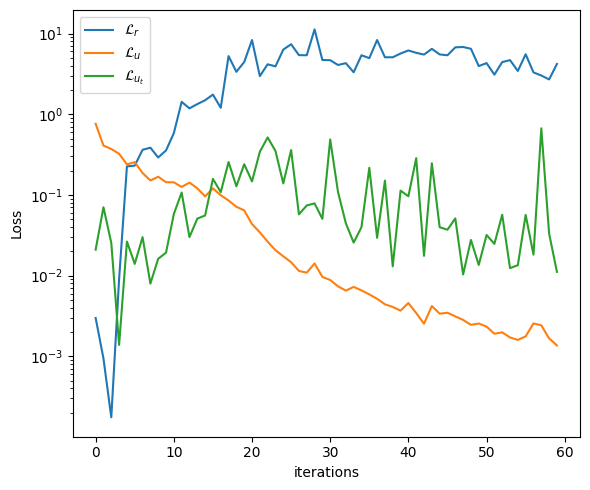

In [20]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
example = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], example)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], example)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
R_star = r(X_star, a, c)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 9.752516e-02


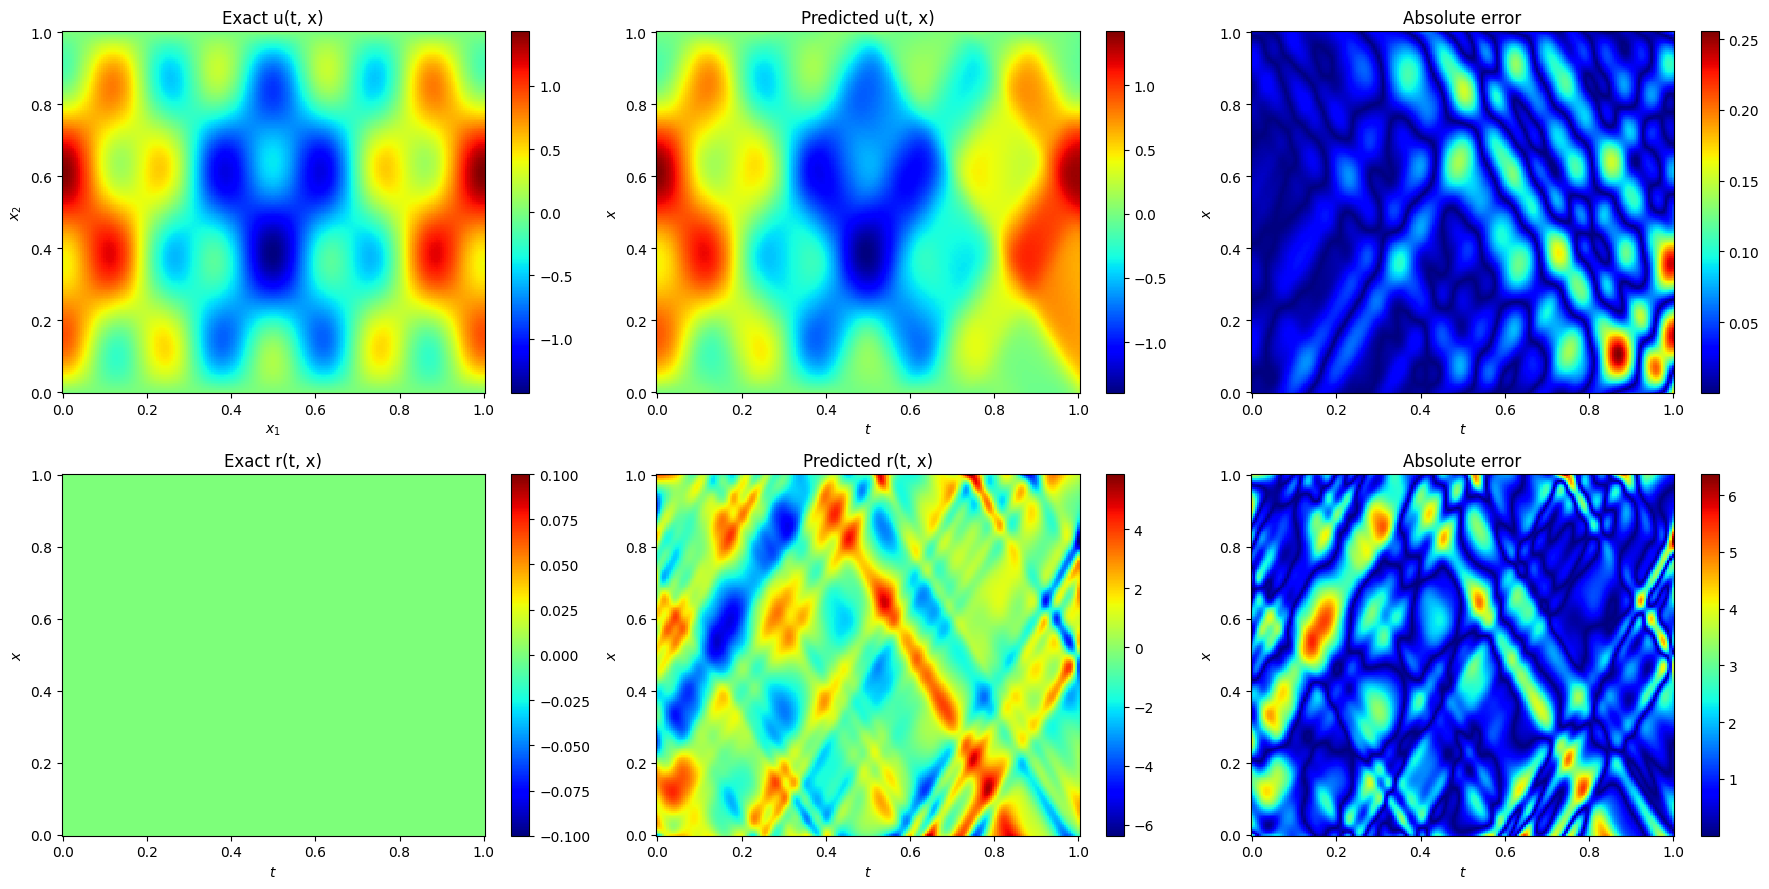

In [22]:
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
R_star = griddata(X_star, R_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, R_star, cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, R_pred, cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(R_star - R_pred), cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [23]:
# Create empty lists for storing the eigenvalues of NTK
lam_K_u_log = []
lam_K_ut_log = []
lam_K_r_log = []

# Restore the NTK
K_u_list = model.K_u_log
K_ut_list = model.K_ut_log
K_r_list = model.K_r_log

K_list = []
    
for k in range(len(K_u_list)):
    K_u = K_u_list[k]
    K_ut = K_ut_list[k]
    K_r = K_r_list[k]
    
    # Compute eigenvalues
    lam_K_u, _ = np.linalg.eig(K_u)
    lam_K_ut, _ = np.linalg.eig(K_ut)
    lam_K_r, _ = np.linalg.eig(K_r)
    # Sort in descresing order
    lam_K_u = np.sort(np.real(lam_K_u))[::-1]
    lam_K_ut = np.sort(np.real(lam_K_ut))[::-1]
    lam_K_r = np.sort(np.real(lam_K_r))[::-1]
    
    # Store eigenvalues
    lam_K_u_log.append(lam_K_u)
    lam_K_ut_log.append(lam_K_ut)
    lam_K_r_log.append(lam_K_r)

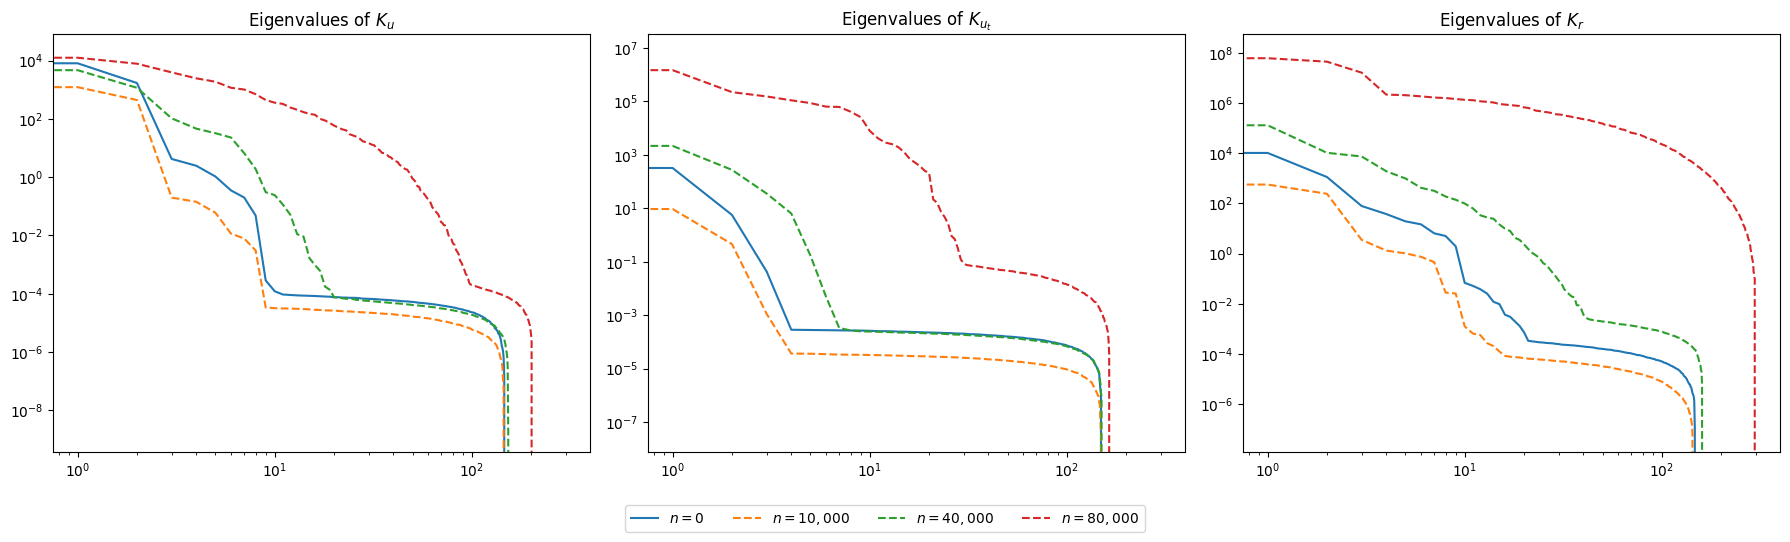

In [24]:
#  Eigenvalues of NTK
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)

plt.plot(lam_K_u_log[0], label = '$n=0$')
plt.plot(lam_K_u_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_u_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_u_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')

plt.title(r'Eigenvalues of ${K}_u$')

plt.subplot(1,3,2)
plt.plot(lam_K_ut_log[0], label = '$n=0$')
plt.plot(lam_K_ut_log[1], '--',label = '$n=10,000$')
plt.plot(lam_K_ut_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_ut_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{u_t}$')

ax =plt.subplot(1,3,3)
plt.plot(lam_K_r_log[0], label = '$n=0$')
plt.plot(lam_K_r_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_r_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_r_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{r}$')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.02),
            borderaxespad=0, bbox_transform=fig.transFigure, ncol=4)
plt.tight_layout()
plt.show()


In [25]:
if update_lam == True:

  lam_u_log = model.lam_u_log
  lam_ut_log = model.lam_ut_log
  lam_r_log = model.lam_r_log

  # Array operations
  LAM_U_LOG = np.array(lam_u_log).flatten()
  LAM_UT_LOG = np.array(lam_ut_log).flatten()
  LAM_R_LOG = np.array(lam_r_log).flatten()

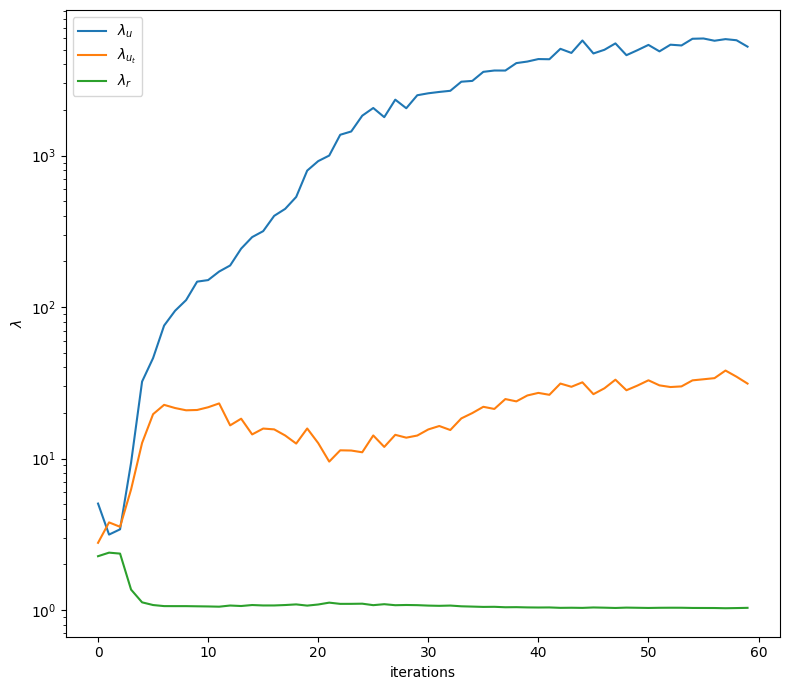

In [26]:
fig = plt.figure(figsize=(8, 7))
plt.plot(LAM_U_LOG, label='$\lambda_u$')
plt.plot(LAM_UT_LOG, label='$\lambda_{u_t}$')
plt.plot(LAM_R_LOG, label='$\lambda_{r}$')
plt.xlabel('iterations')
plt.ylabel('$\lambda$')
plt.yscale('log')
plt.legend( )
plt.tight_layout()
plt.show()